# TP Calibration

Read, understand, and complete and run the following notebook. You must return the completed notebook, including your answers and illustrations (you may need to add cells to write your code or comments). 

To execute a notebook, you will need to [install jupyter](http://jupyter.org/install.html). If you are using anaconda (strongly advised). If you cannot/don't want to use notebooks, you can return both your python code and a report in pdf. Note that the TPs was done using python2, if you are using python3, you might need to do a few changes to the provided code.


## 1. Imports:

In [1]:
import pandas as pd

In [4]:
import numpy as np 
# this is the key library for manipulating arrays. Use the online ressources! http://www.numpy.org/

import matplotlib.pyplot as plt 
# used to read images, display and plot http://matplotlib.org/api/pyplot_api.html . 
#You can also check this simple intro to using ipython notebook with images https://matplotlib.org/users/image_tutorial.html

%matplotlib inline 
# to display directly in the notebook

import scipy.ndimage as ndimage
# one of several python libraries for image procession

import scipy.io as sio
# usefull for loading mat files

import scipy.optimize as optimize
# usefull for optimization

plt.rcParams['image.cmap'] = 'gray' 
# by default, the grayscale images are displayed with the jet colormap: use grayscale instead

**Download the [data](http://imagine.enpc.fr/~aubrym/lectures/introvis17/clean_points.mat ) and load it:**

In [5]:
data=sio.loadmat('clean_points.mat')
pts2d=data['pts2d']
pts3d=data['pts3d']

<span style="color:lightgrey">pts2d and pts3d are two vector of corresponding points in the image and in 3D. We will use these correspondences to calibrate the camera.

## 2. Questions

**1: Build the matrix A that defines the calibration equation (slide 72 in the lecture, the matrix A such that A.P=0, P being the vector of the calibration matrix parameters and 0 being a vector)**

we want to compute the following matrix:
$
\begin{equation*}
A = 
\begin{pmatrix}
0^{T} & X_{1}^{T}  & -y_1 X^{T}_{1} \\
X_{1}^{T} & 0^{T}  & -x_1 X^{T}_{1} \\
\vdots  & \vdots   & \vdots  \\
0^{T} & X_{n}^{T}  & -y_1 X^{T}_{n} \\
X_{n}^{T} & 0^{T}  & -x_1 X^{T}_{n}
\end{pmatrix}
\end{equation*}
$
, such that $A \cdot P = 0$

we first need to homegeneize the coordinates (put them in the form of a 2 by 2 matrix). we can then proceed to compute the matrix.

In [6]:
def calibration_matrix(pts2d,pts3d):
    pts = pts2d.shape[0]
    A=[]
    
    for i in range(pts):
        Xi,Yi,Zi = pts3d[i,0] ,pts3d[i,1], pts3d[i,2]
        xi,yi = pts2d[i,0],pts2d[i,1]
        
        ax = [Xi,Yi,Zi,1] # homogeneous coord. in 3D: X
        bx = [0,0,0,0] # 0^T (homogeneous with the rest)
        cx = [-xi*Xi,-xi*Yi,-xi*Zi,-xi] # -xi * X
        
        ay = [0,0,0,0]
        by = [Xi,Yi,Zi,1] 
        cy = [-yi*Xi,-yi*Yi,-yi*Zi,-yi] # -yi * X
        
        A.append(np.hstack((np.transpose(ay),np.transpose(by),np.transpose(cy))).ravel()) # [ [ 0^T   Xi^T  -yi * Xi^T ]
        A.append(np.hstack((np.transpose(ax),np.transpose(bx),np.transpose(cx))).ravel()) #   [ Xi^T  0^T   -xi * Yi^T ] ... ]
         
    return np.array(A)

In [7]:
A = calibration_matrix(pts2d,pts3d)

___
**2: Perform SVD (using np.linalg.svd) on A. Check that the SVD is coherent and that one of the singular value is close to 0. Use this SVD to compute the projection matrix.**

In [8]:
def projection_matrix(pts2d, pts3d, check = False):
    A = calibration_matrix(pts2d,pts3d)
    
    # perform SVD
    U,s,V =  np.linalg.svd(A)
    V_norm = V[-1,:]/V[-1,-1]
    projection_matrix = V_norm.reshape(3, 4)
    
    # verifications
    def verify(A,U,s,V):
        # check that one singular value is close to 0
        sv0 = "and no singular value is close to 0 (within 0.1 of 0)"
        for i in s:
            if np.isclose(i,0,atol=0.1):
                sv0 = "and one of the singular values is close to 0 (within 0.1 of 0)"
                break
                
        # build A from SVD and check if close to real A
        S = np.zeros((U.shape[1], V.shape[0])) # S height equal to width of U, S width equal to height of V (for correct multiplication)
        S[:12,:12] = np.diag(s) # add singular values 
        for i in np.isclose(U.dot(S).dot(V),A):
            for j in range(len(i)):
                if not i[j]:
                    return "The SVD is incoherent", sv0
        return "The SVD is coherent", sv0
    
    if check: print(verify(A,U,s,V)[0],verify(A,U,s,V)[1])
    
    return projection_matrix

In [9]:
P = projection_matrix(pts2d, pts3d, check = True)

The SVD is coherent and one of the singular values is close to 0 (within 0.1 of 0)


___
**3: Write a function that computes the measurment error between the projected 3D points with a matrix P and the 2D points.**

let's compute the mean square error between projected 3D points and 2D points. Since we also have to compute the projected points, I will also put an argument to be able to recover them later.

In [10]:
def error(P, pts2d, pts3d, proj=False, error_array=False):
    n = len(pts2d)
    
    # later on, optimize.leastsq can't handle multidimensional data...
    if P.shape == (12,):
        P = P.reshape((3,4))
    
    pts3d = np.hstack((pts3d, np.ones((n, 1))))
    pts3d_proj = np.dot(P, pts3d.T).T
    
    x_proj = pts3d_proj[:, 0] / pts3d_proj[:, 2] # 2D projected x
    y_proj = pts3d_proj[:, 1] / pts3d_proj[:, 2] # 2D projected y
    
    def reprojection_error(observed_pts, projected_pts):
        error = np.sqrt((observed_pts - projected_pts)**2)
        #error = error[:,:2]
        return error.flatten()
    
    proj3d = np.array([x_proj,y_proj]).T
    
    if error_array:
        return reprojection_error(pts2d,proj3d)
    
    else:
        mse = sum(reprojection_error(pts2d,proj3d))/len(reprojection_error(pts2d,pts2d)) # error
        return proj3d if proj else mse

In [11]:
error(P,pts2d,pts3d)

0.5438525613630288

___
**4: Visualize the projected 3D points and the 2D points on the same figure (use plt.scatter with different 'marker' options)**

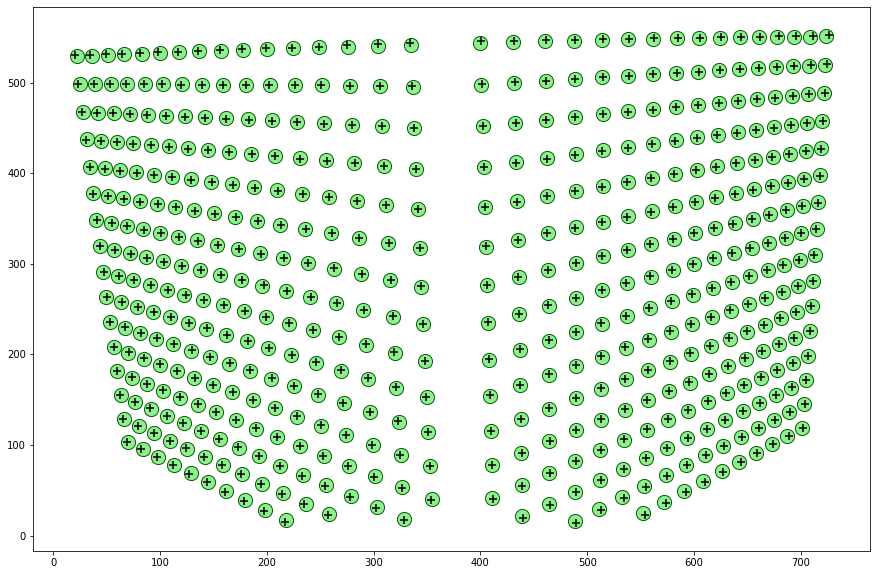

In [12]:
proj3d = error(P, pts2d, pts3d,proj=True)

# visualization
fig = plt.figure(figsize=(15,10))

plt.scatter(pts2d[:,0],pts2d[:,1],s=200,c='lightgreen',edgecolors='darkgreen')
plt.scatter(proj3d[:,0],proj3d[:,1],s=50,marker='+',c='black')

___
**5: Extract the intrinsic and extrinsic parameters of the camera from the matrix (slides 90-95, use np.linalg.norm, np.linalg.inv, np.dot, np.cross...) Note: the sign of rho is not easy to decide a priori, you can take it positive and see if your final calibration makes sense (is the object in front of the camera?)**

from the projection matrix, we can decompose it in intrinsic and extrinsic parameters: $M = K [R | t]$, with $K$ being internal calibration matrix, $R$ the rotation matrix and $t$ the transform matrix. $K$ forms the intrinsic parameters, and $[R|t]$ form the extrinsic parameters

we have:
$
\begin{equation*}
K = 
\begin{pmatrix}
\gamma f & sf    & x_0 \\
0   & f  & y_0 \\
0   & 0    & 1
\end{pmatrix}
\end{equation*}
$
, with $f$ being the focal lenght, $\gamma$ the aspect ratio, $s$ the axis skew, and $x_0$ and $y_0$ the principal point offset.

We have $P = K[R|t] = [KR | Kt]$ which we can write as: $K = [M | b]$, with $M = KR$ where $R$ is the rotation matrix and $K$ the intrinsic calibration matrix

$M$ is square, so we can do an $RQ$-decomposition: $K$ is upper triangular matrix and $R$ an orthogonal basis.

Since $R$ is orthogonal, we have: $MM^{T} = (KR)(KR)^T = K R R^{T} K^{T} = K \mathcal{I}_3 K^{T} = K K^T$. 

Since $M$ and $b$ can be directly obtained from $P$, we have a way to determine $K$ and the intrinsic parameters $R$ and $t$.

We start by computing $MM^{T}$ and normalizing by the lower right value (since $K$'s lower right value should be 1 it is easier to start with $M$ in the correct form)

We can compute it:
$
\begin{equation}
MM^{T} = KK^{T}
= 
\begin{pmatrix}
\gamma f & sf    & x_0 \\
0   & f  & y_0 \\
0   & 0    & 1
\end{pmatrix}
\times
\begin{pmatrix}
\gamma f & 0    & 0 \\
     sf  & f     & 0 \\
     x_0   & y_0     & 1
\end{pmatrix}
=
\begin{pmatrix}
  (\gamma f)^{2} + (sf)^{2} + x_{0}^{2}  &    (sf) f + x_0 y_0     &  x_0 \\
    (sf) f + x_0 y_0     &    f^{2} + y_{0}^{2}    &  y_0 \\
    x_0    &  y_0   &  1
\end{pmatrix}
\end{equation}
$

from there, we're going to build $K$ first: we can directly recover from $MM^T$ the values of $x_0$ and $y_0$

with these values, we can progressively find $f$, $sf$, and $\gamma f$, from which we can recover the values of $s$ and $\gamma$ at the end.

finally, we can build K from the recovered values.

since $M = KR$ and $b = Kt$, we can compute $R = K^{-1}M$ and $t = -K^{-1}b$

Since the calibration isn't abslute, we add a factor rho in front of $P$, and we'll look at its value and it's consequences in more detail down the line.



The approach used was inspired by Kyle Simek's blog post on the subject: http://ksimek.github.io/2013/08/13/intrinsic/ and Carl Olsson's Computer Vision notes: http://www.maths.lth.se/matematiklth/personal/calle/datorseende13/notes/forelas3.pdf

In [20]:
def parameters(P,epsilon):
    # decompose P = [M|b] with M = [a1,a2,a3] and b = [b1,b2,b3]
    a1 = P[0,:3]
    a2 = P[1,:3]
    a3 = P[2,:3]
    
    b1 = P[0,3:4]
    b2 = P[1,3:4]
    b3 = P[2,3:4]
    
    rho = epsilon/np.linalg.norm(a3)
    
    M = rho*(np.array((a1,a2,a3)))
    b = np.array((b1,b2,b3))
        
    # since we have M, we can easily compute MM^T
    MM_transpose = M.dot(M.T)
    # we want to obtain an upper triangular with position [2,2] = 1:
    MM_transpose = MM_transpose/MM_transpose[2,2]
    
    # as seen in the explanation above, we directly obtain x0 and y0
    x0 = MM_transpose[0,2]
    y0 = MM_transpose[1,2]
    
    # only depends on y0
    f = np.sqrt(MM_transpose[1,1] - y0**2)
    
    # f + x0 + yo:
    sf = (MM_transpose[0,1] - x0*y0)/f
    
    # sf + x0:
    gammaf = np.sqrt(MM_transpose[0,0] - sf**2 -x0**2)
    
    # we can recover the skew parameter:
    s = sf/f
    
    # and the aspect ratio parameter:
    gamma = gammaf/f
    
    # as seen above
    K = np.array([[ gamma*f, s*f,    x0],
                  [   0,      f,     y0], 
                  [   0,      0,      1]])
    
    # extrinsic parameters
    R = np.linalg.inv(K).dot(M)
    t = -rho*np.linalg.inv(K).dot(b)
    
    return K,R,t 

In [21]:
K,R,t = parameters(P,epsilon=1)
K,R,t

(array([[9.70284101e+02, 9.86348414e-02, 3.72004964e+02],
        [0.00000000e+00, 9.63346581e+02, 2.99292094e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[ 0.71171772,  0.03054192, -0.70180131],
        [ 0.18731413, -0.97113272,  0.14769783],
        [ 0.67703124,  0.23657647,  0.6968933 ]]),
 array([[   2.05879063],
        [ -91.40400685],
        [-297.70374576]]))

We need to choose an epsilon such as the determinant of $R$ is positive:

In [22]:
np.linalg.det(R)

-0.9999999999999993

With $\epsilon = 1$, the determinant of the rotation matrix is negative (object behind the camera). So we need to take $\epsilon = -1$:

In [23]:
K,R,t = parameters(P,epsilon=-1)
K,R,t

(array([[9.70284101e+02, 9.86348414e-02, 3.72004964e+02],
        [0.00000000e+00, 9.63346581e+02, 2.99292094e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[-0.71171772, -0.03054192,  0.70180131],
        [-0.18731413,  0.97113272, -0.14769783],
        [-0.67703124, -0.23657647, -0.6968933 ]]),
 array([[ -2.05879063],
        [ 91.40400685],
        [297.70374576]]))

In [24]:
np.linalg.det(R)

0.9999999999999993

The calibration now makes sense

___
**6: Improve the estimate of the camera matrix using non linear least square (use optimize.leastsq which implements a variant of Levenberg-Marquardt and the function of question 3) Compare the reprojection error before and after the optimization.**

In [15]:
P_opt, P_opt_sol = optimize.leastsq(error, P.flatten(),args=(pts2d,pts3d,False,True))
print("the least square method has found",P_opt_sol,"solution(s)")

proj3d = error(P,pts2d,pts3d,proj=True)
proj3d_opt = error(P_opt,pts2d,pts3d,proj=True)

the least square method has found 1 solution(s)


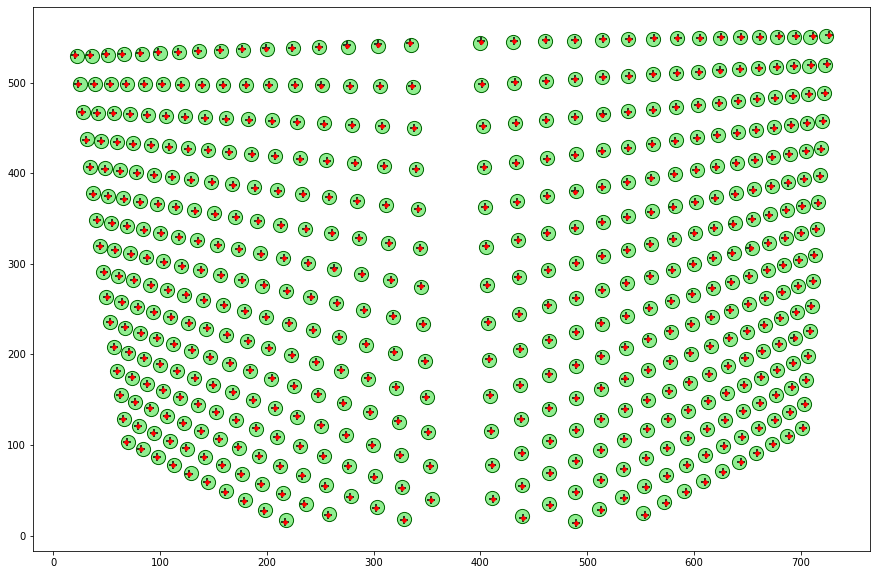

In [16]:
# visualization
fig = plt.figure(figsize=(15,10))

plt.scatter(pts2d[:,0], pts2d[:,1], s=200, color='lightgreen', edgecolors='darkgreen')
plt.scatter(proj3d[:,0], proj3d[:,1], s=50, marker='+', color='black')
plt.scatter(proj3d_opt[:,0], proj3d_opt[:,1], s=10, marker='D', color='red')

In [17]:
error(P,pts2d,pts3d)-error(P_opt,pts2d,pts3d)

-0.0009574048788105749

It seems that the error after optimization is bigger than before: bad use of leastsq? choose a better measure? 